In [1]:
from simpletransformers.ner import NERModel, NERArgs
import numpy as np
import pandas as pd
from transformers import BertModel
from torch import nn
from tqdm.auto import tqdm, trange
from torch.optim import Adam, SGD
import torch
from torch.utils.data import DataLoader, TensorDataset


class BertOnBLSTM(nn.Module):
    def __init__(self, bert_dim, output_dim, num_layers, rnn_dim):
        super(BertOnBLSTM, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.rnn = nn.LSTM(bert_dim, rnn_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(rnn_dim*2, output_dim)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, x, y, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        loss = self.loss_function(output, y)
        return loss

    def test(self, x, y, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        loss = self.loss_function(output, y)
        predict = self.predict_label(output.transpose(1, 2), mask)
        return loss, predict

    def predict(self, x, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        return output.transpose(1, 2).argmax(2)

    def predict_label(self, output, mask):
        """
        output: batch_size, max_sentence_len, tag_num
        mask: same label data
        batch_label: batch_size, sentence_label
        """
        pre_label = []
        pre_label_pad = output.argmax(2)
        for i in range(mask.shape[0]):
            sent_label = []
            for j in range(mask.shape[1]):
                if mask[i, j] == 1:
                    sent_label.append(pre_label_pad[i, j].item())
            sent_label = sent_label[1:len(sent_label)-1]
            pre_label.append(sent_label)

        return pre_label


In [2]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]

In [3]:
model_args = NERArgs()
model_args.overwrite_output_dir = True
model_args.save_steps = -1
ner_model = NERModel('bert',
                 'bert-base-uncased',
                 labels = labels_set,
                 args=model_args,
                 use_cuda=False)
ner_model.args.max_seq_length = 512

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
train_df = pd.read_csv('./wikitext/train0-10.csv').dropna()
validation_df = pd.read_csv('./wikitext/validation.csv').dropna()

In [ ]:
train_dataset = ner_model.load_and_cache_examples(train_df[:])
validation_dataset = ner_model.load_and_cache_examples(validation_df[:])

In [ ]:
len(train_dataset), len(validation_dataset)

In [8]:
bert_dim = 768
output_dim = len(labels_set)
batch_size = 32
adam_lr = 3e-5
epoch = 1
num_layers = 1
rnn_dim = 512
model = BertOnBLSTM(bert_dim, output_dim, num_layers, rnn_dim)

def train(model, tr_ds, val_ds):
    use_gpu = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_gpu else 'cpu')
    train_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=False)
    validation_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    
    
    if use_gpu:
        model.to(device)
    optimizer = Adam(model.parameters(), lr=adam_lr)
    for i in range(epoch):
        epoch_loss = 0
        batch_iterator = tqdm(train_dataloader, desc=f"Running Epoch {i+1} of {epoch}", mininterval=0)
        
        for (j, batch) in enumerate(batch_iterator):
            batch_x = batch[0].to(device)
            batch_y = batch[3].to(device)
            batch_seg = batch[2].to(device)
            batch_msk = batch[1].to(device)
            loss = model(batch_x, batch_y, batch_seg, batch_msk)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        dev_loss = 0
        predict_idx_label = []

        for (h, val_batch) in enumerate(validation_dataloader):
            val_batch_x = val_batch[0].to(device)
            val_batch_y = val_batch[3].to(device)
            val_batch_seg = val_batch[2].to(device)
            val_batch_msk = val_batch[1].to(device)
            with torch.no_grad():
                loss_val, pre_y = model.test(val_batch_x, val_batch_y, val_batch_seg, val_batch_msk)
            dev_loss += loss_val.item()            
            predict_idx_label.append(pre_y)
        print(f"Epoch {i+1}/{epoch}:\n\tTraining Loss: \t\t{epoch_loss/(j+1):9.4f}\n\tValidation Loss: \t{dev_loss/(h+1):9.4f}")
        print('*******************************************************')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train(model, train_dataset, validation_dataset)

In [ ]:
print(model)


In [4]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


In [32]:
def flatten_chunk(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [33]:
flatten_chunk(list(chunks([1,2,3,4,5,6,7,8,9], 4)))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from simpletransformers.ner.ner_utils import InputExample

def test_model(to_predict, predictor_model, ner_model):
    predict_examples = [InputExample(i,sentence.split(),[ner_model.args.labels_list[0] for word in sentence.lower().split()],) for i, sentence in enumerate(to_predict)]
    eval_dataset = ner_model.load_and_cache_examples(None, evaluate=True, no_cache=True, to_predict=predict_examples)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=batch_size)
    
    batch_to_predict = list(chunks(to_predict, batch_size))
    eval_batch_iterator = tqdm(eval_dataloader, desc=f"Testing!", mininterval=0)
    use_gpu = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_gpu else 'cpu')
    model.to(device)
    final_preds = []
    for (j, val_batch) in enumerate(eval_batch_iterator):
        val_batch_x = val_batch[0].to(device)
        val_batch_y = val_batch[3].to(device)
        val_batch_seg = val_batch[2].to(device)
        val_batch_msk = val_batch[1].to(device)
        with torch.no_grad():
            pre_y = predictor_model.predict(val_batch_x, val_batch_seg, val_batch_msk)
        out_label_ids = [[] for _ in range(len(val_batch_x))]

        max_len = np.max([len(x) for x in val_batch_x])
        for index, sentence in enumerate(batch_to_predict[j]):
            for word in sentence.split():
                word_tokens = ner_model.tokenizer.tokenize(word)
                out_label_ids[index].extend([0] + [-100] * (len(word_tokens) - 1))
            out_label_ids[index].insert(0, -100)
            out_label_ids[index].append(-100)
            if len(out_label_ids[index]) < max_len:
                out_label_ids[index].extend([-100] * (max_len - len(out_label_ids[index])))
        xfer_label_ids = np.zeros((len(out_label_ids), max_len))
        for i, out_label_id in enumerate(out_label_ids):
            for j, label in enumerate(out_label_id):
                xfer_label_ids[i][j] = np.int32(label)
        out_label_ids = np.array([list(x) for x in out_label_ids], np.int32)
        preds = pre_y.to("cpu")
        label_map = {i: label for i, label in enumerate(labels_set)}
        out_label_list = [[] for _ in range(out_label_ids.shape[0])]
        preds_list = [[] for _ in range(out_label_ids.shape[0])]
        for i in range(out_label_ids.shape[0]):
            for j in range(out_label_ids.shape[1]):
                if out_label_ids[i, j] != -100:
                    out_label_list[i].append(label_map[out_label_ids[i][j]])
                    preds_list[i].append(label_map[preds[i][j].item()])
        final_preds.append(preds_list)
    return flatten_chunk(final_preds)

In [35]:
to_predict = ["First the reading points out that it is imperative for the employees to participate in meetings because meetings are effective for talking about controversial subjects", "This is in direct contrast with the statement of the listening which contends that meetings should be avoided", "He explains that in long meetings bosses spend time reciting introductory information Thus employees do not pay attention in a meeting exceeding an hour Therefore he suggests that the employees politely decline the meeting pointing at a pressing obligation that can be done through a quick phone call or email", "In addition the writer says that it employees should make effort to read all of the training and supplementary material", "When reading such articles the author explains that it is instrumental for the employees to pay attention to the details of the text However the professor refutes this argument claiming that employees should rather try to find the main idea rather than focusing on the intricate details since it takes up an unnecessary amount of time", "He goes as far to claim that employees should refuse to read the entire material even if their bosses request them to do so",
             "Finally according to the reading employees should write their report in one attempt Since the employees are no longer in university they no longer have the luxury to waste time in separating the steps when writing This is challenged by the argument of the listening material that when one does not separate the steps in writing it can be more tire time consuming Thus the professor recommends that the employees write divide the writing into three distinct steps creating an outline writing a first draft and revising the essay In this way the professor ascertains that employees will be able to complete their writing in a timely and accurate manner Finally according to the reading employees should write their report in one attempt Since the employees are no longer in university they no longer have the luxury to waste time in separating the steps when writing This is challenged by the argument of the listening material that when one does not separate the steps in writing it can be more tire time consuming Thus the professor recommends that the employees write divide the writing into three distinct steps creating an outline writing a first draft and revising the essay In this way the professor ascertains that employees will be able to complete their writing in a timely and accurate manner"]
out_labels = test_model(to_predict=to_predict, predictor_model=model, ner_model=ner_model)

for i, sent in enumerate(to_predict):
    print(len(sent.split()))
    print(len(out_labels[i]))
print(out_labels)


  0%|          | 0/1 [00:00<?, ?it/s]

Testing!:   0%|          | 0/1 [00:00<?, ?it/s]

25
25
18
18
50
50
20
20
56
56
24
24
220
220
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [ ]:
torch.save(model.state_dict(), "./bert_on_blstm_models/0/model.json")

In [2]:
### To Load Later

In [36]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]

bert_dim = 768
output_dim = len(labels_set)
batch_size = 32
adam_lr = 3e-5
epoch = 1
num_layers = 1
rnn_dim = 512

model = BertOnBLSTM(bert_dim, output_dim, num_layers, rnn_dim)
model.load_state_dict(torch.load("./bert_on_blstm_models/0/model.json"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [37]:
import pandas as pd

testdf = pd.read_csv('./preprocessed_wikitext/test.csv').dropna()

In [39]:
groups = [df for _, df in testdf.groupby('sentence_id')]

In [52]:
to_predicts = []
true_labels = []
for i, sentence in enumerate(groups):
    to_predicts.append(' '.join(sentence['words'].to_list()))
    true_labels.append(sentence['labels'].to_list())

In [43]:
preds_list = test_model(to_predict=to_predicts, predictor_model=model, ner_model=ner_model)

  0%|          | 0/5 [00:00<?, ?it/s]

Testing!:   0%|          | 0/68 [00:00<?, ?it/s]

In [54]:
for i in range(len(preds_list)):
    if(len(preds_list[i]) != len(true_labels[i])):
        print('THIS IS NOT GOOD', i)

In [56]:
import itertools
ps = list(itertools.chain.from_iterable(preds_list))
ts = list(itertools.chain.from_iterable(true_labels))

In [57]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=ts,y_pred=ps, labels=labels_set)
cm

array([[     0,      0,      0,      0,      0,      0,  11091],
       [     0,      0,      0,      0,      0,      0,   8891],
       [     0,      0,      0,      0,      0,      0,     12],
       [     0,      0,      0,      0,      0,      0,     20],
       [     0,      0,      0,      0,      0,      0,    310],
       [     0,      0,      0,      0,      0,      0,    547],
       [     0,      0,      0,      0,      0,      0, 194821]])

In [58]:
import numpy as np
summ = np.sum(cm, axis=1)
summ = np.expand_dims(summ, axis=1)

In [59]:
nor_cm = (cm/summ)
nor_cm

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [60]:
nor_cm.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

In [61]:
from sklearn import metrics 
print(metrics.classification_report(ts, ps))

/home/mostafa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     I-COLON       0.00      0.00      0.00       310
     I-COMMA       0.00      0.00      0.00     11091
       I-DOT       0.00      0.00      0.00      8891
     I-EMARK       0.00      0.00      0.00        20
     I-QMARK       0.00      0.00      0.00        12
 I-SEMICOLON       0.00      0.00      0.00       547
           O       0.90      1.00      0.95    194821

    accuracy                           0.90    215692
   macro avg       0.13      0.14      0.14    215692
weighted avg       0.82      0.90      0.86    215692



/home/mostafa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(114.0, 0.5, 'True Label')

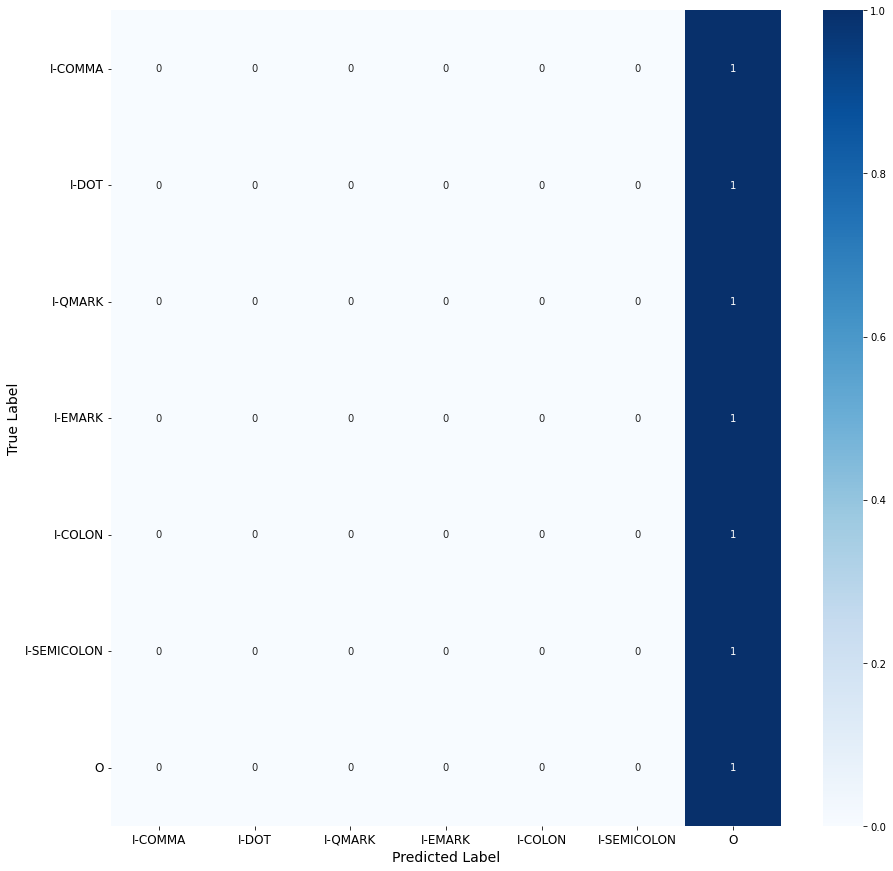

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plot_labels = labels_set
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(nor_cm,
            ax=ax, 
            annot=True,
            cmap='Blues',
            xticklabels=plot_labels,
            yticklabels=plot_labels)
plt.yticks(rotation=0,size=12)
plt.xticks(size=12)
ax.set_xlabel('Predicted Label',size=14)
ax.set_ylabel('True Label',size=14)